In [4]:
import plotly.graph_objs as go
import numpy as np

def read_gii_file(file_path):
    """
    Read scalar data from a GIFTI file
    
    :param file_path: str, path to the GIFTI scalar file
    :return: numpy array of scalar values or None if error
    """
    try:
        gifti_img = nib.load(file_path)
        scalars = gifti_img.darrays[0].data
        return scalars
    except Exception as e:
        print(f"Error loading texture: {e}")
        return None

def extract_band_mesh(vertices, faces, scalars, target_bands, tolerance=0.1):
    """
    Extract only the vertices and faces that belong to specific bands
    
    Parameters:
    - vertices: mesh vertices (N x 3)
    - faces: mesh faces (M x 3) 
    - scalars: texture values (N,)
    - target_bands: list of band values to extract (e.g., [4], [-5], or [4, 5])
    - tolerance: tolerance for band matching (default 0.1)
    
    Returns:
    - new_vertices: vertices for the selected bands
    - new_faces: faces for the selected bands (reindexed)
    - new_scalars: scalar values for the selected bands
    - vertex_map: mapping from old to new vertex indices
    """
    
    # Create mask for vertices belonging to target bands
    vertex_mask = np.zeros(len(vertices), dtype=bool)
    
    for band in target_bands:
        # Use tolerance for floating point comparison
        band_mask = np.abs(scalars - band) <= tolerance
        vertex_mask |= band_mask
    
    # Get indices of selected vertices
    selected_vertex_indices = np.where(vertex_mask)[0]
    
    if len(selected_vertex_indices) == 0:
        print(f"No vertices found for bands {target_bands}")
        return None, None, None, None
    
    # Extract vertices and scalars
    new_vertices = vertices[vertex_mask]
    new_scalars = scalars[vertex_mask]
    
    # Create mapping from old vertex indices to new ones
    vertex_map = {old_idx: new_idx for new_idx, old_idx in enumerate(selected_vertex_indices)}
    
    # Extract faces that have all vertices in the selected set
    valid_faces = []
    for face in faces:
        if all(vertex_idx in vertex_map for vertex_idx in face):
            # Remap face indices to new vertex array
            new_face = [vertex_map[vertex_idx] for vertex_idx in face]
            valid_faces.append(new_face)
    
    if len(valid_faces) == 0:
        print(f"No complete faces found for bands {target_bands}")
        return new_vertices, None, new_scalars, vertex_map
    
    new_faces = np.array(valid_faces)
    
    print(f"Extracted {len(new_vertices)} vertices and {len(new_faces)} faces for bands {target_bands}")
    
    return new_vertices, new_faces, new_scalars, vertex_map

def plot_band_parcels(vertices, faces, scalars, target_bands, camera=None, title=None, 
                      show_as_points=False, point_size=3):
    """
    Plot only the mesh parcels for specific bands as floating objects
    
    Parameters:
    - vertices, faces, scalars: original mesh data
    - target_bands: list of bands to visualize
    - camera: camera configuration
    - title: plot title
    - show_as_points: if True, show as point cloud instead of mesh
    - point_size: size of points if show_as_points=True
    """
    
    # Extract mesh for target bands
    band_vertices, band_faces, band_scalars, vertex_map = extract_band_mesh(
        vertices, faces, scalars, target_bands
    )
    
    if band_vertices is None:
        return None
    
    # Create color mapping
    colors = []
    band_colors = {
        -6: '#FF0000', -5: '#00FF00', -4: '#0000FF',
        -3: '#92c5de', -2: '#d1e5f0', -1: '#f7f7f7',
        1: '#fddbc7', 2: '#f4a582', 3: '#d6604d',
        4: '#d6604d', 5: '#b2182b', 6: '#67001f'
    }
    
    # Assign colors based on band values
    for scalar in band_scalars:
        band = int(round(scalar))
        colors.append(band_colors.get(band, '#808080'))  # Default to gray
    
    traces = []
    
    if show_as_points or band_faces is None:
        # Show as point cloud
        trace = go.Scatter3d(
            x=band_vertices[:, 0],
            y=band_vertices[:, 1], 
            z=band_vertices[:, 2],
            mode='markers',
            marker=dict(
                size=point_size,
                color=colors,
                opacity=0.8
            ),
            name=f'Bands {target_bands}',
            hovertemplate='Band: %{text}<br>Coordinates: (%{x:.2f}, %{y:.2f}, %{z:.2f})<extra></extra>',
            text=[f'B{int(round(s))}' for s in band_scalars]
        )
        traces.append(trace)
    else:
        # Show as mesh
        trace = go.Mesh3d(
            x=band_vertices[:, 0],
            y=band_vertices[:, 1],
            z=band_vertices[:, 2],
            i=band_faces[:, 0],
            j=band_faces[:, 1], 
            k=band_faces[:, 2],
            intensity=band_scalars,
            intensitymode='vertex',
            colorscale=[[0, colors[0]], [1, colors[0]]] if len(set(colors)) == 1 else 'Viridis',
            showscale=False,
            opacity=0.8,
            name=f'Bands {target_bands}',
            hovertemplate='Band: %{intensity:.0f}<extra></extra>'
        )
        traces.append(trace)
    
    # Create figure
    fig = go.Figure(data=traces)
    
    # Update layout
    layout_dict = dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False), 
            zaxis=dict(visible=False),
            camera=camera,
            bgcolor='white'  # Black background to make parcels stand out
        ),
        height=900,
        width=1000,
        margin=dict(l=10, r=10, b=10, t=50 if title else 10),
        showlegend=True,
        paper_bgcolor='white',
        plot_bgcolor='white'
    )
    
    if title:
        layout_dict['title'] = dict(
            text=title,
            x=0.5,
            y=0.95,
            xanchor='center', 
            yanchor='top',
            font=dict(size=20, color='black')
        )
    
    fig.update_layout(**layout_dict)
    
    return fig

def plot_multiple_bands_separately(vertices, faces, scalars, bands_list, camera=None):
    """
    Create separate plots for each band, showing them as individual floating parcels
    
    Parameters:
    - vertices, faces, scalars: original mesh data
    - bands_list: list of individual bands to plot separately (e.g., [4, 5, 6])
    - camera: camera configuration
    
    Returns:
    - List of figures, one for each band
    """
    figures = []
    
    for band in bands_list:
        fig = plot_band_parcels(
            vertices, faces, scalars, 
            target_bands=[band],
            camera=camera,
            title=f'Band B{band} Parcels',
            show_as_points=False
        )
        if fig is not None:
            figures.append(fig)
    
    return figures

def mesh_orientation(mesh, hemisphere):
    '''Function to orient mesh for proper visualisation
    Parameters:
    mesh: loaded mesh file to be visualized
    hemisphere: hemisphere of mesh being visualized
    
    Returns:
    Oriented mesh and medial and lateral camera configuration'''

    # Define hemisphere

    hemisphere = str(hemisphere).lower()

    # Set configuration and transformation according to hemisphere
    if hemisphere == 'right':
        # mesh.apply_transform(mesh.principal_inertia_transform)
        transfo_180 = np.array([[-1, 0, 0, 0],[0, 1, 0, 0],[0, 0, -1, 0], [0, 0, 0, 1]])
        transfo_90 = np.array([
            [1, 0, 0, 0],    # First row
            [0, 0, 1, 0],    # Second row
            [0, -1, 0, 0],   # Third row
            [0, 0, 0, 1]     # Fourth row
        ])
        mesh.apply_transform(transfo_180)
        # Example camera positions (you can modify these as needed)
        camera_lateral = dict(
            eye=dict(x=2, y=0, z=0),    # Camera position from lateral side
            center=dict(x=0, y=0, z=0),  # Looking at center
            up=dict(x=0, y=0, z=-1)      # Up vector points in negative z direction
        )

        camera_medial = dict(
            eye=dict(x=-2, y=0, z=0),    # Camera position from medial side
            center=dict(x=0, y=0, z=0),   # Looking at center
            up=dict(x=0, y=0, z=-1)       # Up vector points in negative z direction
        )

        
    elif hemisphere == 'left':
        # mesh.apply_transform(mesh.principal_inertia_transform)
        transfo_180 = np.array([[-1, 0, 0, 0],[0, 1, 0, 0],[0, 0, -1, 0], [0, 0, 0, 1]])
        transfo_90 = np.array([
            [1, 0, 0, 0],    # First row
            [0, 0, 1, 0],    # Second row
            [0, -1, 0, 0],   # Third row
            [0, 0, 0, 1]     # Fourth row
        ])
        mesh.apply_transform(transfo_180)
        # Example camera positions (you can modify these as needed)
        camera_lateral = dict(
            eye=dict(x=2, y=0, z=0),    # Camera position from lateral side
            center=dict(x=0, y=0, z=0),  # Looking at center
            up=dict(x=0, y=0, z=-1)      # Up vector points in negative z direction
        )

        camera_medial = dict(
            eye=dict(x=-2, y=0, z=0),    # Camera position from medial side
            center=dict(x=0, y=0, z=0),   # Looking at center
            up=dict(x=0, y=0, z=-1)       # Up vector points in negative z direction
        )
    
    else:
        print('Invalid hemisphere parameter')

    return mesh, camera_medial, camera_lateral




In [ ]:
import os 
import slam.io as sio

# Define file paths
directory = "/home/INT/dienye.h/python_files/rough/mesh"
tex_dir = '/home/INT/dienye.h/python_files/rough/spangy_dom_band_textures'
output_dir = "/home/INT/dienye.h/python_files/rough/generated/"

# Specify the exact files to process
mesh_filename = "smooth_5_sub-001_ses-01_hemi-L_white.gii"  # Change this to your specific mesh file
texture_filename = "spangy_dom_band_sub-001_ses-01_hemi-L_white.gii.gii"  # Change this to your specific texture file

# Define band groups
gyri = [4, 5, 6]
sulci = [-6, -5, -4]

# Clean filenames for participant session extraction
clean_mesh_filename = mesh_filename.replace("smooth_5_", "") if mesh_filename.startswith("smooth_5_") else mesh_filename
clean_texture_filename = texture_filename.replace("spangy_dom_band_", "").replace(".gii.gii", ".gii")

# Verify files match after cleaning
if clean_mesh_filename == clean_texture_filename:
    participant_session = clean_texture_filename.split('_')[0] + '_' + clean_texture_filename.split('_')[1]
    
    print(f"Processing file pair:")
    print(f"  Mesh: {mesh_filename} -> {clean_mesh_filename}")
    print(f"  Texture: {texture_filename} -> {clean_texture_filename}")
    print(f"  Participant session: {participant_session}")
    
    # Load mesh data
    mesh_file = os.path.join(directory, mesh_filename)
    if not os.path.exists(mesh_file):
        print(f"Error: Mesh file not found: {mesh_file}")
        exit()
        
    mesh = sio.load_mesh(mesh_file)
    mesh, camera_medial, camera_lateral = mesh_orientation(mesh, 'left')
    vertices = mesh.vertices
    faces = mesh.faces
    
    # Load texture data
    tex_file = os.path.join(tex_dir, texture_filename)
    if not os.path.exists(tex_file):
        print(f"Error: Texture file not found: {tex_file}")
        exit()
        
    loc_dom_band_texture = read_gii_file(tex_file)
    
    # Verify texture was loaded successfully
    if loc_dom_band_texture is None:
        print(f"Failed to load texture: {texture_filename}")
        exit()
    
    # Verify vertex count matches
    if len(vertices) != len(loc_dom_band_texture):
        print(f"Error: Vertex count mismatch for {participant_session}")
        print(f"Mesh vertices: {len(vertices)}, Texture values: {len(loc_dom_band_texture)}")
        exit()
        
    print(f"Successfully loaded mesh and texture for {participant_session}")
    print(f"Vertices: {len(vertices)}, Faces: {len(faces)}, Texture values: {len(loc_dom_band_texture)}")
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Plot only B4 parcels as floating objects
    print("Generating B4 parcels visualization...")
    fig_b4 = plot_band_parcels(
        vertices=vertices,
        faces=faces, 
        scalars=loc_dom_band_texture,
        target_bands=[4],
        camera=camera_lateral,
        title=f'{participant_session} - Band B4 Parcels Only'
    )
    
    # Plot only B5 parcels
    print("Generating B5 parcels visualization...")
    fig_b5 = plot_band_parcels(
        vertices=vertices,
        faces=faces,
        scalars=loc_dom_band_texture, 
        target_bands=[5],
        camera=camera_lateral,
        title=f'{participant_session} - Band B5 Parcels Only'
    )
    
    # Plot multiple bands as separate floating parcels in one figure
    print("Generating multi-band gyri parcels visualization...")
    fig_multi = plot_band_parcels(
        vertices=vertices,
        faces=faces,
        scalars=loc_dom_band_texture,
        target_bands=gyri,  # Show B4, B5, B6 together
        camera=camera_lateral,
        title=f'{participant_session} - Gyri Bands (B4, B5, B6) Parcels'
    )
    
    # Plot sulci bands
    print("Generating sulci parcels visualization...")
    fig_sulci = plot_band_parcels(
        vertices=vertices,
        faces=faces,
        scalars=loc_dom_band_texture,
        target_bands=sulci,  # Show B-6, B-5, B-4 together
        camera=camera_lateral,
        title=f'{participant_session} - Sulci Bands (B-6, B-5, B-4) Parcels'
    )
    
    # Save the figures
    if fig_b4:
        output_path = f"{output_dir}{participant_session}_B4_parcels.png"
        fig_b4.write_image(output_path)
        print(f"Saved B4 parcels: {output_path}")
        
    if fig_b5:
        output_path = f"{output_dir}{participant_session}_B5_parcels.png"
        fig_b5.write_image(output_path)
        print(f"Saved B5 parcels: {output_path}")
        
    if fig_multi:
        output_path = f"{output_dir}{participant_session}_gyri_parcels.png"
        fig_multi.write_image(output_path)
        print(f"Saved gyri parcels: {output_path}")
        
    if fig_sulci:
        output_path = f"{output_dir}{participant_session}_sulci_parcels.png"
        fig_sulci.write_image(output_path)
        print(f"Saved sulci parcels: {output_path}")
        
    print("Processing completed successfully!")
    
else:
    print("Error: Mesh and texture filenames do not match after cleaning")
    print(f"Cleaned mesh: {clean_mesh_filename}")
    print(f"Cleaned texture: {clean_texture_filename}")

In [2]:
import os 
import slam.io as sio
import nibabel as nib

# Example usage with your existing code:
# Iterate through mesh files and find matching texture files

gyri = [1, 2, 3]
sulci = [-3, -2, -1]


# Example Usage

directory = "/home/INT/dienye.h/python_files/rough/mesh"  # Add your directory path here
tex_dir = '/home/INT/dienye.h/python_files/rough/spangy_dom_band_textures'

for filename in os.listdir(directory):
    matching_texture_found = False
    
    # Clean mesh filename by removing "smooth_5_" prefix
    clean_mesh_filename = filename.replace("smooth_5_", "").replace("reo-SVR-output-brain-mask-brain_bounti-white.", "").replace(".surf", "") if filename.startswith("smooth_5_") else filename
    
    for file in os.listdir(tex_dir):
        # Remove the prefix and keep one .gii to match with mesh filename
        clean_texture_filename = file.replace("smooth_5_spangy_dom_band_", "")
        
        # Check if cleaned mesh and texture files match
        if clean_mesh_filename == clean_texture_filename:
            matching_texture_found = True
            participant_session = clean_texture_filename.split('_')[0] + '_' + clean_texture_filename.split('_')[1]
            
            print(f"Processing matched pair:")
            print(f"  Mesh: {filename} -> {clean_mesh_filename}")
            print(f"  Texture: {file} -> {clean_texture_filename}")
            
            # Load mesh data
            mesh_file = os.path.join(directory, filename)
            mesh = sio.load_mesh(mesh_file)
            mesh, camera_medial, camera_lateral = mesh_orientation(mesh, 'left')
            vertices = mesh.vertices
            faces = mesh.faces
            
            # Load texture data
            tex_file = os.path.join(tex_dir, file)
            loc_dom_band_texture = read_gii_file(tex_file)
            
            # Verify texture was loaded successfully
            if loc_dom_band_texture is None:
                print(f"Failed to load texture: {file}")
                continue
            
            # Verify vertex count matches
            if len(vertices) != len(loc_dom_band_texture):
                print(f"Warning: Vertex count mismatch for {participant_session}")
                print(f"Mesh vertices: {len(vertices)}, Texture values: {len(loc_dom_band_texture)}")
                continue
                
            print(f"Successfully matched mesh and texture for {participant_session}")
            
            # Plot only B4 parcels as floating objects
            fig_b4 = plot_band_parcels(
                vertices=vertices,
                faces=faces, 
                scalars=loc_dom_band_texture,
                target_bands=[-1],
                camera=camera_lateral,
                title=f'{participant_session} - Band B1 Parcels Only'
            )
            
            # Plot only B5 parcels
            fig_b5 = plot_band_parcels(
                vertices=vertices,
                faces=faces,
                scalars=loc_dom_band_texture, 
                target_bands=[-2],
                camera=camera_lateral,
                title=f'{participant_session} - Band B2 Parcels Only'
            )
            # Plot only B6 parcels
            fig_b6 = plot_band_parcels(
                vertices=vertices,
                faces=faces,
                scalars=loc_dom_band_texture, 
                target_bands=[-3],
                camera=camera_lateral,
                title=f'{participant_session} - Band B3 Parcels Only'
            )
            
            # Plot multiple bands as separate floating parcels in one figure
            fig_multi = plot_band_parcels(
                vertices=vertices,
                faces=faces,
                scalars=loc_dom_band_texture,
                target_bands=[-1, -2, -3],  # Show B4, B5, B6 together
                camera=camera_lateral,
                title=f'{participant_session} - Gyri Bands (B4, B5, B6) Parcels'
            )
            
            # Save the figures
            output_dir = "/home/INT/dienye.h/python_files/rough/generated"
            if fig_b4:
                fig_b4.write_image(f"{output_dir}{participant_session}_B1_parcels.png")
                print(f"Saved B1 parcels: {participant_session}_B1_parcels.png")
                
            if fig_b5:
                fig_b5.write_image(f"{output_dir}{participant_session}_B2_parcels.png")
                print(f"Saved B2 parcels: {participant_session}_B2_parcels.png")

            if fig_b6:
                fig_b6.write_image(f"{output_dir}{participant_session}_B3_parcels.png")
                print(f"Saved B3 parcels: {participant_session}_B3_parcels.png")                
                
            if fig_multi:
                fig_multi.write_image(f"{output_dir}{participant_session}_B1-B3_sulci_parcels.png")
                print(f"Saved multi-band parcels: {participant_session}_B1-B3_sulci_parcels.png")
                
            # Break out of texture file loop since we found the match
            break
    
    if not matching_texture_found:
        print(f"No matching texture found for mesh file: {filename} (cleaned: {clean_mesh_filename})")

Processing matched pair:
  Mesh: smooth_5_sub-0858_ses-0995_reo-SVR-output-brain-mask-brain_bounti-white.right.surf.gii -> sub-0858_ses-0995_right.gii
  Texture: smooth_5_spangy_dom_band_sub-0858_ses-0995_right.gii -> sub-0858_ses-0995_right.gii
Successfully matched mesh and texture for sub-0858_ses-0995
No vertices found for bands [-1]
Extracted 133 vertices and 53 faces for bands [-2]
Extracted 1731 vertices and 1912 faces for bands [-3]
Extracted 1864 vertices and 1977 faces for bands [-1, -2, -3]
Saved B2 parcels: sub-0858_ses-0995_B2_parcels.png
Saved B3 parcels: sub-0858_ses-0995_B3_parcels.png
Saved multi-band parcels: sub-0858_ses-0995_B1-B3_sulci_parcels.png
No matching texture found for mesh file: dhcp_mesh (cleaned: dhcp_mesh)
Processing matched pair:
  Mesh: smooth_5_sub-0858_ses-0995_reo-SVR-output-brain-mask-brain_bounti-white.left.surf.gii -> sub-0858_ses-0995_left.gii
  Texture: smooth_5_spangy_dom_band_sub-0858_ses-0995_left.gii -> sub-0858_ses-0995_left.gii
Successful

In [ ]:
import os 
import slam.io as sio
import nibabel as nib

# Example usage with your existing code:
# Iterate through mesh files and find matching texture files

gyri = [4, 5, 6]
sulci = [-6, -5, -4]


# Example Usage

directory = "/home/INT/dienye.h/python_files/rough/mesh"  # Add your directory path here
tex_dir = '/home/INT/dienye.h/python_files/rough/spangy_dom_band_textures'

for filename in os.listdir(directory):
    matching_texture_found = False
    
    # Clean mesh filename by removing "smooth_5_" prefix
    clean_mesh_filename = filename.replace("smooth_5_", "").replace("reo-SVR-output-brain-mask-brain_bounti-white.", "").replace(".surf", "") if filename.startswith("smooth_5_") else filename
    
    for file in os.listdir(tex_dir):
        # Remove the prefix and keep one .gii to match with mesh filename
        clean_texture_filename = file.replace("smooth_5_spangy_dom_band_", "")
        
        # Check if cleaned mesh and texture files match
        if clean_mesh_filename == clean_texture_filename:
            matching_texture_found = True
            participant_session = clean_texture_filename.split('_')[0] + '_' + clean_texture_filename.split('_')[1]
            
            print(f"Processing matched pair:")
            print(f"  Mesh: {filename} -> {clean_mesh_filename}")
            print(f"  Texture: {file} -> {clean_texture_filename}")
            
            # Load mesh data
            mesh_file = os.path.join(directory, filename)
            mesh = sio.load_mesh(mesh_file)
            mesh, camera_medial, camera_lateral = mesh_orientation(mesh, 'left')
            vertices = mesh.vertices
            faces = mesh.faces
            
            # Load texture data
            tex_file = os.path.join(tex_dir, file)
            loc_dom_band_texture = read_gii_file(tex_file)
            
            # Verify texture was loaded successfully
            if loc_dom_band_texture is None:
                print(f"Failed to load texture: {file}")
                continue
            
            # Verify vertex count matches
            if len(vertices) != len(loc_dom_band_texture):
                print(f"Warning: Vertex count mismatch for {participant_session}")
                print(f"Mesh vertices: {len(vertices)}, Texture values: {len(loc_dom_band_texture)}")
                continue
                
            print(f"Successfully matched mesh and texture for {participant_session}")
            
            # Plot only B4 parcels as floating objects
            fig_b4 = plot_band_parcels(
                vertices=vertices,
                faces=faces, 
                scalars=loc_dom_band_texture,
                target_bands=[-4],
                camera=camera_lateral,
                title=f'{participant_session} - Band B4 Parcels Only'
            )
            
            # Plot only B5 parcels
            fig_b5 = plot_band_parcels(
                vertices=vertices,
                faces=faces,
                scalars=loc_dom_band_texture, 
                target_bands=[-5],
                camera=camera_lateral,
                title=f'{participant_session} - Band B5 Parcels Only'
            )
            # Plot only B5 parcels
            fig_b6 = plot_band_parcels(
                vertices=vertices,
                faces=faces,
                scalars=loc_dom_band_texture, 
                target_bands=[-6],
                camera=camera_lateral,
                title=f'{participant_session} - Band B6 Parcels Only'
            )
            
            # Plot multiple bands as separate floating parcels in one figure
            fig_multi = plot_band_parcels(
                vertices=vertices,
                faces=faces,
                scalars=loc_dom_band_texture,
                target_bands=[-4, -5, -6],  # Show B4, B5, B6 together
                camera=camera_lateral,
                title=f'{participant_session} - Gyri Bands (B4, B5, B6) Parcels'
            )
            
            # Save the figures
            output_dir = "/home/INT/dienye.h/python_files/rough/generated"
            if fig_b4:
                fig_b4.write_image(f"{output_dir}{participant_session}_B4_parcels.png")
                print(f"Saved B4 parcels: {participant_session}_B4_parcels.png")
                
            if fig_b5:
                fig_b5.write_image(f"{output_dir}{participant_session}_B5_parcels.png")
                print(f"Saved B5 parcels: {participant_session}_B5_parcels.png")

            if fig_b6:
                fig_b6.write_image(f"{output_dir}{participant_session}_B6_parcels.png")
                print(f"Saved B6 parcels: {participant_session}_B6_parcels.png")                
                
            if fig_multi:
                fig_multi.write_image(f"{output_dir}{participant_session}_gyri_parcels.png")
                print(f"Saved multi-band parcels: {participant_session}_gyri_parcels.png")
                
            # Break out of texture file loop since we found the match
            break
    
    if not matching_texture_found:
        print(f"No matching texture found for mesh file: {filename} (cleaned: {clean_mesh_filename})")

In [ ]:
import plotly.graph_objs as go
import numpy as np
import nibabel as nib
import slam.io as sio
import slam.texture as stex
import os
import pandas as pd


import plotly.graph_objs as go
import numpy as np

def read_gii_file(file_path):
    """
    Read scalar data from a GIFTI file
    
    :param file_path: str, path to the GIFTI scalar file
    :return: numpy array of scalar values or None if error
    """
    try:
        gifti_img = nib.load(file_path)
        scalars = gifti_img.darrays[0].data
        return scalars
    except Exception as e:
        print(f"Error loading texture: {e}")
        return None

def create_custom_colormap():
    """
    Create a custom colormap for values from -6 to 6
    Returns both the colormap and the discrete colors for the legend
    """
    # Define colors for negative values (cool colors)
    negative_colors = [
        '#FF0000', # red
        '#00FF00', # green
        '#0000FF', # blue
        '#92c5de',  # very light blue
        '#d1e5f0',  # pale blue
        '#f7f7f7',  # very pale blue for B-1
    ]
    
    # Define colors for positive values (warm colors)
    positive_colors = [
        '#fddbc7',  # pale red
        '#f4a582',  # light red
        '#d6604d',  # medium red
        '#d6604d',  # medium red
        '#b2182b',  # dark red
        '#67001f',  # very dark red
    ]
    
    # Create color mapping for legend
    value_color_map = {}
    for i, color in enumerate(reversed(negative_colors)):
        value_color_map[-(i+1)] = color
    for i, color in enumerate(positive_colors):
        value_color_map[i+1] = color
        
    # Create continuous colorscale
    colorscale = []
    
    # Add negative colors
    for i, color in enumerate(negative_colors):
        pos = i / (len(negative_colors) - 1) * 0.5
        colorscale.append([pos, color])
    
    # Add positive colors
    for i, color in enumerate(positive_colors):
        pos = 0.5 + (i / (len(positive_colors) - 1) * 0.5)
        colorscale.append([pos, color])
    
    return colorscale, value_color_map

def plot_mesh_with_legend(vertices, faces, scalars, view_type='both', selected_bands=None, camera=None, title=None):
    """
    Plot mesh with custom legend instead of colorbar
    
    Parameters:
    - vertices: mesh vertices
    - faces: mesh faces
    - scalars: texture values
    - view_type: 'both', 'positive', or 'negative'
    - camera: camera position dictionary
    - title: plot title
    """
    # Create custom colormap and value-color mapping
    colorscale, value_color_map = create_custom_colormap()
    
    # Create a copy of scalars to modify
    display_scalars = scalars.copy()
    
    # Apply band selection if specified
    if selected_bands is not None:
        # Convert all values not in selected_bands to NaN
        mask = np.zeros_like(display_scalars, dtype=bool)
        for band in selected_bands:
            mask |= (np.round(display_scalars) == band)
        display_scalars[~mask] = np.nan
    
    # Apply view filtering after band selection
    if view_type == 'positive':
        display_scalars[display_scalars < 0] = np.nan
    elif view_type == 'negative':
        display_scalars[display_scalars > 0] = np.nan
    
    # Clip values to our range of interest (-6 to 6)
    display_scalars = np.clip(display_scalars, -6, 6)
    
    # Create the mesh
    mesh = go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=faces[:, 0],
        j=faces[:, 1],
        k=faces[:, 2],
        intensity=display_scalars,
        intensitymode='vertex',
        colorscale=colorscale,
        cmin=-6,
        cmax=6,
        showscale=False,  # Hide the colorbar
        hovertemplate='Value: %{intensity:.2f}<extra></extra>'
    )
    
    # Create legend items
    legend_traces = []
    
    # Function to add legend items based on view type
    def add_legend_items(values):
        for val in values:
            color = value_color_map[val]
            legend_traces.append(
                go.Scatter3d(
                    x=[None],
                    y=[None],
                    z=[None],
                    mode='markers',
                    marker=dict(size=10, color=color),
                    name=f'B{val}',
                    showlegend=True
                )
            )
    
    # Add legend items based on selected bands and view type
    if selected_bands is not None:
        # Sort selected bands to maintain legend order
        sorted_bands = sorted(selected_bands)
        add_legend_items([b for b in sorted_bands if 
                         (b < 0 and view_type in ['both', 'negative']) or
                         (b > 0 and view_type in ['both', 'positive'])])
    else:
        # Default behavior if no bands are selected
        if view_type in ['both', 'negative']:
            add_legend_items(range(-6, 0))
        if view_type in ['both', 'positive']:
            add_legend_items(range(1, 7))
    
    # Create the figure
    fig = go.Figure(data=[mesh] + legend_traces)
    
    # Update layout
    layout_dict = dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            camera=camera
        ),
        height=900,
        width=1000,
        margin=dict(l=10, r=10, b=10, t=50 if title else 10),
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99,
            bgcolor='rgba(255, 255, 255, 0.8)'
        )
    )
    
    if title:
        layout_dict['title'] = dict(
            text=title,
            x=0.5,
            y=0.95,
            xanchor='center',
            yanchor='top',
            font=dict(size=20)
        )
    
    fig.update_layout(**layout_dict)
    
    return fig


def mesh_orientation(mesh, hemisphere):
    '''Function to orient mesh for proper visualisation
    Parameters:
    mesh: loaded mesh file to be visualized
    hemisphere: hemisphere of mesh being visualized
    
    Returns:
    Oriented mesh and medial and lateral camera configuration'''

    # Define hemisphere

    hemisphere = str(hemisphere).lower()

    # Set configuration and transformation according to hemisphere
    if hemisphere == 'right':
        # mesh.apply_transform(mesh.principal_inertia_transform)
        transfo_180 = np.array([[-1, 0, 0, 0],[0, 1, 0, 0],[0, 0, -1, 0], [0, 0, 0, 1]])
        transfo_90 = np.array([
            [1, 0, 0, 0],    # First row
            [0, 0, 1, 0],    # Second row
            [0, -1, 0, 0],   # Third row
            [0, 0, 0, 1]     # Fourth row
        ])
        mesh.apply_transform(transfo_180)
        # Example camera positions (you can modify these as needed)
        camera_lateral = dict(
            eye=dict(x=2, y=0, z=0),    # Camera position from lateral side
            center=dict(x=0, y=0, z=0),  # Looking at center
            up=dict(x=0, y=0, z=-1)      # Up vector points in negative z direction
        )

        camera_medial = dict(
            eye=dict(x=-2, y=0, z=0),    # Camera position from medial side
            center=dict(x=0, y=0, z=0),   # Looking at center
            up=dict(x=0, y=0, z=-1)       # Up vector points in negative z direction
        )

        
    elif hemisphere == 'left':
        # mesh.apply_transform(mesh.principal_inertia_transform)
        transfo_180 = np.array([[-1, 0, 0, 0],[0, 1, 0, 0],[0, 0, -1, 0], [0, 0, 0, 1]])
        transfo_90 = np.array([
            [1, 0, 0, 0],    # First row
            [0, 0, 1, 0],    # Second row
            [0, -1, 0, 0],   # Third row
            [0, 0, 0, 1]     # Fourth row
        ])
        mesh.apply_transform(transfo_180)
        # mesh.apply_transform(transfo_180)
        # Example camera positions (you can modify these as needed)
        camera_lateral = dict(
            eye=dict(x=2, y=0, z=0),    # Camera position from lateral side
            center=dict(x=0, y=0, z=0),  # Looking at center
            up=dict(x=0, y=0, z=-1)      # Up vector points in negative z direction
        )

        camera_medial = dict(
            eye=dict(x=-2, y=0, z=0),    # Camera position from medial side
            center=dict(x=0, y=0, z=0),   # Looking at center
            up=dict(x=0, y=0, z=-1)       # Up vector points in negative z direction
        )
    
    else:
        print('Invalid hemisphere parameter')

    return mesh, camera_medial, camera_lateral


#Set band values for gyri and sulci (positive band values correspond to gyri, negative to sulci)
gyri = [4, 5, 6]
sulci = [-6, -5, -4]


# Example Usage

directory = "/home/INT/dienye.h/python_files/rough/rough_surf"  # Add your directory path here
tex_dir = '/home/INT/dienye.h/python_files/rough/rough_tex_spangy'


# Collect vertex counts from all meshes
for filename in os.listdir(directory):
    original_filename = filename
    filename = filename.replace("test_display_smooth_5_dt_10_", "").replace("reo-SVR-output-brain-mask-brain_bounti-white.", "").replace(".surf", "") if filename.startswith("test_display_smooth_5_dt_10_") else filename
    for file in os.listdir(tex_dir):
        # Remove the prefix and keep one .gii
        clean_filename = file.replace("smooth_5_spangy_dom_band_", "").replace(".gii.gii", ".gii")
        if filename == clean_filename:
            participant_session = clean_filename.split('_')[0] + '_' + clean_filename.split('_')[1]
        #Load meshfile
            mesh_file = os.path.join(directory, original_filename)
            mesh = sio.load_mesh(mesh_file)
            mesh, camera_medial, camera_lateral = mesh_orientation(mesh, 'left') # mesh of left brain hemisphere
            # mesh.apply_transform(mesh.principal_inertia_transform)
            vertices = mesh.vertices
            faces = mesh.faces

            # Load generated texture
            tex_file = os.path.join(tex_dir, file)
            loc_dom_band_texture = read_gii_file(tex_file)

            sulci = [-6, -5, -4]
            fig = plot_mesh_with_legend(
                vertices=mesh.vertices,
                faces=mesh.faces,
                scalars=loc_dom_band_texture,
                selected_bands=sulci,  # Will show only sulci bands 4, 5, 6
                camera=camera_lateral,
                title='Negative Bands Visualization'
            )
            fig.write_image(f"/home/INT/dienye.h/python_files/rough/rough_tex_spangy/{participant_session}.png")







smooth_5_sub-0858_ses-0995_reo-SVR-output-brain-mask-brain_bounti-white.left.surf.gii
smooth_5_sub-0858_ses-0995_reo-SVR-output-brain-mask-brain_bounti-white.left.surf.gii
test_display_smooth_10_sub-0858_ses-0995_reo-SVR-output-brain-mask-brain_bounti-white.left.surf.gii
test_display_smooth_10_sub-0858_ses-0995_reo-SVR-output-brain-mask-brain_bounti-white.left.surf.gii
sub-0858_ses-0995_left.gii
sub-0858_ses-0995_left.gii


Detecting outliers using 95% confidence intervals...

Processing band_power_B4...
  Outliers found: 28 (4.75%)

Processing band_power_B5...
  Outliers found: 36 (6.11%)

Processing band_power_B6...
  Outliers found: 36 (6.11%)

Summary:
Original dataframe shape: (589, 55)
Clean dataframe shape: (510, 55)
Outliers dataframe shape: (79, 55)
Total percentage of outliers: 13.41%

Files saved:
- clean_data.csv: Data without outliers
- outliers_data.csv: Outlier data only

Generating plots...


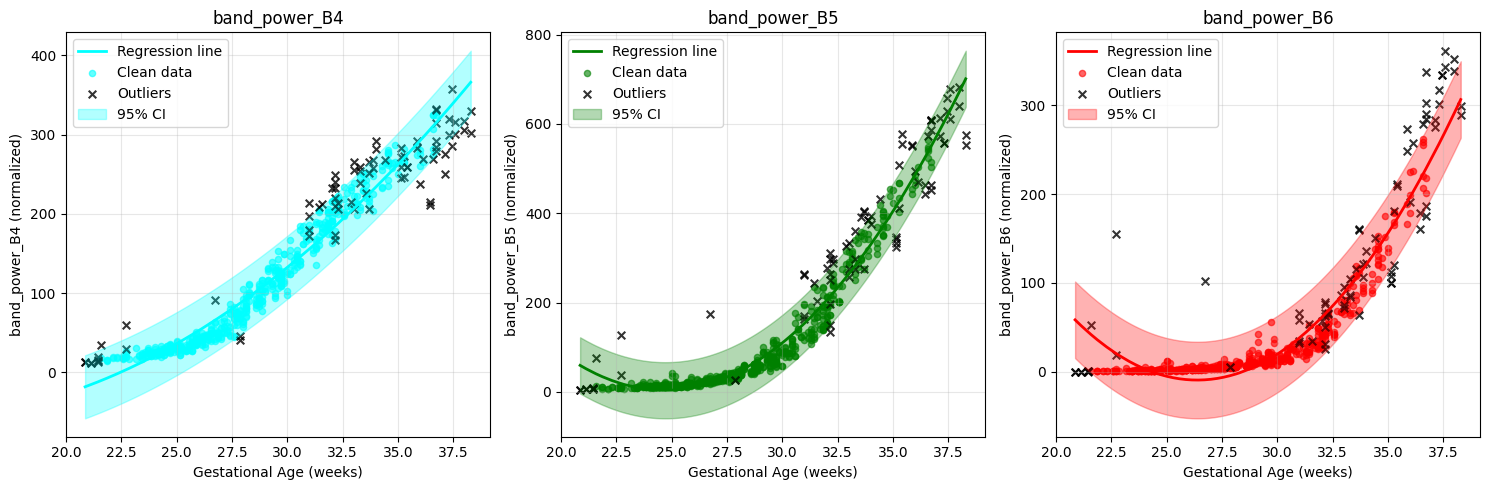

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def detect_outliers_confidence_interval(df, age_column, band_columns, confidence_level=0.95):
    """
    Detect outliers that fall outside the confidence interval when band power
    columns are plotted against gestational age.
    
    Parameters:
    df: pandas DataFrame - original dataframe
    age_column: str - column name for gestational age
    band_columns: list - band power columns to check
    confidence_level: float - confidence level (default 0.95 for 95%)
    
    Returns:
    tuple: (clean_df, outliers_df, models_info)
    """
    
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Remove any rows with NaN values in the relevant columns
    relevant_columns = [age_column] + band_columns
    df_copy = df_copy.dropna(subset=relevant_columns)
    
    # Initialize outlier mask
    outlier_mask = pd.Series(False, index=df_copy.index)
    models_info = {}
    
    alpha = 1 - confidence_level
    
    for band_col in band_columns:
        print(f"\nProcessing {band_col}...")
        
        # Extract data
        X = df_copy[age_column].values.reshape(-1, 1)
        y = df_copy[band_col].values
        
        # Fit polynomial regression (you can adjust the degree as needed)
        # Degree 2 seems appropriate for the curved relationship in your image
        poly_reg = Pipeline([
            ('poly', PolynomialFeatures(degree=2)),
            ('linear', LinearRegression())
        ])
        
        poly_reg.fit(X, y)
        y_pred = poly_reg.predict(X)
        
        # Calculate residuals and standard error
        residuals = y - y_pred
        mse = np.mean(residuals**2)
        std_error = np.sqrt(mse)
        
        # Calculate degrees of freedom
        n = len(y)
        p = 3  # number of parameters for degree 2 polynomial (intercept + x + x^2)
        df_residual = n - p
        
        # Calculate t-critical value for confidence interval
        t_critical = stats.t.ppf(1 - alpha/2, df_residual)
        
        # Calculate confidence interval bounds
        margin_of_error = t_critical * std_error
        upper_bound = y_pred + margin_of_error
        lower_bound = y_pred - margin_of_error
        
        # Identify outliers (points outside confidence interval)
        band_outliers = (y > upper_bound) | (y < lower_bound)
        outlier_mask |= band_outliers
        
        # Store model information
        models_info[band_col] = {
            'model': poly_reg,
            'predictions': y_pred,
            'upper_bound': upper_bound,
            'lower_bound': lower_bound,
            'std_error': std_error,
            'outlier_count': np.sum(band_outliers),
            'outlier_percentage': (np.sum(band_outliers) / len(y)) * 100
        }
        
        print(f"  Outliers found: {np.sum(band_outliers)} ({(np.sum(band_outliers) / len(y)) * 100:.2f}%)")
    
    # Separate outliers and clean data
    outliers_df = df_copy[outlier_mask].copy()
    clean_df = df_copy[~outlier_mask].copy()
    
    return clean_df, outliers_df, models_info

def plot_results(df, clean_df, outliers_df, models_info, age_column, band_columns):
    """
    Plot the results showing the confidence intervals and outliers
    """
    fig, axes = plt.subplots(1, len(band_columns), figsize=(15, 5))
    if len(band_columns) == 1:
        axes = [axes]
    
    colors = ['cyan', 'green', 'red']
    
    for i, band_col in enumerate(band_columns):
        ax = axes[i]
        
        # Plot clean data
        ax.scatter(clean_df[age_column], clean_df[band_col], 
                  alpha=0.6, color=colors[i], s=20, label='Clean data')
        
        # Plot outliers
        if len(outliers_df) > 0:
            ax.scatter(outliers_df[age_column], outliers_df[band_col], 
                      alpha=0.8, color='black', s=30, marker='x', label='Outliers')
        
        # Plot regression line and confidence interval
        x_sorted = np.sort(df[age_column].values)
        X_sorted = x_sorted.reshape(-1, 1)
        
        model = models_info[band_col]['model']
        y_pred_sorted = model.predict(X_sorted)
        
        # Calculate confidence interval for sorted data
        residuals = df[band_col].values - models_info[band_col]['predictions']
        std_error = models_info[band_col]['std_error']
        
        n = len(df)
        p = 3
        df_residual = n - p
        t_critical = stats.t.ppf(0.975, df_residual)  # 95% confidence
        margin_of_error = t_critical * std_error
        
        upper_bound_sorted = y_pred_sorted + margin_of_error
        lower_bound_sorted = y_pred_sorted - margin_of_error
        
        ax.plot(x_sorted, y_pred_sorted, color=colors[i], linewidth=2, label='Regression line')
        ax.fill_between(x_sorted, lower_bound_sorted, upper_bound_sorted, 
                       alpha=0.3, color=colors[i], label='95% CI')
        
        ax.set_xlabel('Gestational Age (weeks)')
        ax.set_ylabel(f'{band_col} (normalized)')
        ax.set_title(f'{band_col}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Load your dataframe (replace with your actual file path)
    df = pd.read_csv('/home/INT/dienye.h/python_files/dhcp_dataset_info/combined_results.csv')
    

    
    # Specify the columns
    age_column = 'gestational_age'
    band_columns = ['band_power_B4', 'band_power_B5', 'band_power_B6']
    
    # Detect outliers using confidence intervals
    print("Detecting outliers using 95% confidence intervals...")
    clean_df, outliers_df, models_info = detect_outliers_confidence_interval(
        df, age_column, band_columns, confidence_level=0.95
    )
    
    # Print summary statistics
    print(f"\nSummary:")
    print(f"Original dataframe shape: {df.shape}")
    print(f"Clean dataframe shape: {clean_df.shape}")
    print(f"Outliers dataframe shape: {outliers_df.shape}")
    print(f"Total percentage of outliers: {(len(outliers_df) / len(df)) * 100:.2f}%")
    
    # Save the dataframes to CSV files
    clean_df.to_csv('/home/INT/dienye.h/python_files/dhcp_dataset_info/clean_data.csv', index=False)
    outliers_df.to_csv('/home/INT/dienye.h/python_files/dhcp_dataset_info/outliers_data.csv', index=False)
    
    print("\nFiles saved:")
    print("- clean_data.csv: Data without outliers")
    print("- outliers_data.csv: Outlier data only")
    
    # Plot the results (optional)
    print("\nGenerating plots...")
    plot_results(df, clean_df, outliers_df, models_info, age_column, band_columns)

In [13]:
import slam.io as sio
import slam.texture as stex
import slam.curvature as scurv
import os
import pandas as pd
import time
import slam.spangy as spgy
import numpy as np
import matplotlib.pyplot as plt
import trimesh
import sys
from slam.differential_geometry import laplacian_mesh_smoothing

mesh_file = '/home/INT/dienye.h/python_files/rough/rough_surf/smooth_5_sub-0858_ses-0995_reo-SVR-output-brain-mask-brain_bounti-white.left.surf.gii'
mesh = sio.load_mesh(mesh_file)
mesh = laplacian_mesh_smoothing(mesh, nb_iter=5, dt=10)
filename = 'test_display_smooth_5_dt_10_sub-0858_ses-0995_reo-SVR-output-brain-mask-brain_bounti-white.left.surf'
new_mesh_path = os.path.join('/home/INT/dienye.h/python_files/rough/rough_surf/', '{}.gii'.format(filename))
sio.write_mesh(mesh, new_mesh_path)
mesh.apply_transform(mesh.principal_inertia_transform)

    Smoothing mesh
  Computing Laplacian
    Computing mesh weights of type fem
    -edge length threshold needed for  0  values =  0.0  %
    -number of Nan in weights:  0  =  0.0  %
    -number of Negative values in weights:  62394  =  8.62360163974757  %
    -nb Nan in Laplacian :  0
    -nb Inf in Laplacian :  0
0
1
2
3
4
    OK


<trimesh.Trimesh(vertices.shape=(120589, 3), faces.shape=(241178, 3))>